In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchtext import data, datasets
from torchtext.vocab import Vocab
import torch.optim as optim

import pyprind
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
import time
from tqdm import tqdm
import re
from nltk.corpus import stopwords
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Dataset:Large Movie Review Dataset

Link: https://ai.stanford.edu/~amaas/data/sentiment/

This is a dataset for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

I have already saved this dataset as a csv file

In [124]:
df = pd.read_csv('movie_data.csv', encoding = 'utf-8')
df.head(5)

,text,sentiment
0,This movie is a perfect example of a film that...,1
1,"Composed, elegant Carol (marvelously played by...",1
2,one of the funnest mario's i've ever played. t...,1
3,"This movie is, in all likelihood, the worst fi...",0
4,The one sheets and newspaper campaign suggeste...,0


In [9]:
df.shape

(50000, 2)

Seniment distribution

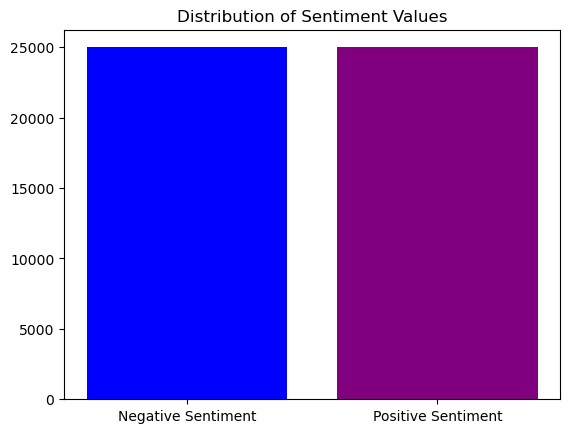

In [50]:
sentiment_counts = [sum(df['sentiment'] == 0), sum(df['sentiment'] == 1)]
sentiment_labels = ['Negative Sentiment', 'Positive Sentiment']

plt.bar(sentiment_labels, sentiment_counts, color=['blue', 'purple'])
plt.title('Distribution of Sentiment Values')

plt.show()

# Logistic Regression Model

We drop character with no meaning and deal with emoticons

In [6]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [23]:
df['text'] = df['text'].apply(preprocessor)

For tokenization we just split the data

In [25]:
def tokenizer(text):
    return text.split()

Train/test split

In [62]:
X_train = df.loc[:25000, 'text'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'text'].values
y_test = df.loc[25000:, 'sentiment'].values

Grid seaching parametrs for LogisticRegression

Using TfidfVectorizer and stop words

In [63]:
stop = set(stopwords.words('english'))

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0, solver='liblinear'))])

In [64]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                            scoring='accuracy',
                            cv=5,
                            verbose=2,
                            n_jobs=-1)
    
gs_lr_tfidf.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Vanyusha\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0], 'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x000001E9B0F31A80>]}],
             scoring='accuracy', verbose=2)

In [67]:
print('Best parameters: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameters: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x000001E9B0F31A80>} 
CV Accuracy: 0.895


In [66]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.898


# LSTM Model

In [8]:
path = 'C:\\Users\\Vanyusha\\Desktop\\datasets\\movie_data.csv'
df_LSTM = pd.read_csv(path, encoding = 'utf-8')

In [9]:
X_train = df_LSTM.loc[:24999, 'text'].values
y_train = df_LSTM.loc[:24999, 'sentiment'].values
X_test = df_LSTM.loc[25000:, 'text'].values
y_test = df_LSTM.loc[25000:, 'sentiment'].values

In [10]:
len(y_test)

25000

In [11]:
len(y_train)

25000

Tockenizer for LSTM

In [14]:
def tockenizer_LSTM(X_train, X_test, vocab_limit):
    word_list = []
    onehot_dict = {}
    train = []
    test = []
    
    #English stopwords from NLTK library to filter out common words
    stop = set(stopwords.words('english'))
    
    for sample in X_train:
        for word in sample.lower().split():
            word = preprocessor(word)
            
            if word not in stop and word != '':
                word_list.append(word)
  
    #Count the frequency of each word in the training data
    vocab = Counter(word_list)
    
    #Sort the vocabulary by word frequency in descending order and limit it to 'vocab_limit' words
    vocab_sorted = sorted(vocab, key=vocab.get, reverse=True)[:vocab_limit]
    
    #Create a one-hot encoding dictionary for the selected words
    for i, w in enumerate(vocab_sorted):
        onehot_dict[w] = i + 1

    #Tokenization of the training data using one-hot encoding
    for sample in X_train:
        sample_tokens = []
        for word in sample.lower().split():
            preprocessed_word = preprocessor(word)
            
            #Check if the preprocessed word exists in the one-hot encoding dictionary
            if preprocessed_word in onehot_dict.keys():
                sample_tokens.append(onehot_dict[preprocessed_word])
        train.append(sample_tokens)
    
    # Tokenization of the test data using the same one-hot encoding dictionary
    for sample in X_test:
        sample_tokens = []
        for word in sample.lower().split():
            preprocessed_word = preprocessor(word)
            if preprocessed_word in onehot_dict.keys():
                sample_tokens.append(onehot_dict[preprocessed_word])
        test.append(sample_tokens)

    return train, test, onehot_dict

Our vocabulary will consist of top 2000 words

In [15]:
X_train, X_test, vocab = tockenizer_LSTM(X_train, X_test, vocab_limit = 2000)

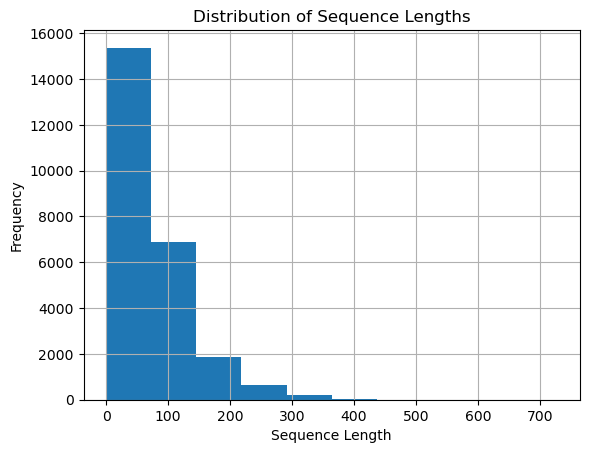

mean     78.567120
max     728.000000
std      55.573276
dtype: float64


In [16]:
text_length = [len(sample) for sample in X_train]

text_length_series = pd.Series(text_length)
text_length_series.hist()
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

description = text_length_series.describe()[['mean', 'max', 'std']]
print(description)

In [17]:
def padding(text, seq_len):
    features = np.zeros((len(text), seq_len), dtype=int)
    for i, review in enumerate(text):
        if len(review) != 0:
            features[i, - len(review):] = np.array(review)[:seq_len]

    return features

Padding with max length = 400

In [18]:
X_train_padded = padding(X_train,400)
X_test_padded = padding(X_test,400)

Creating data loaders (batch_size = 50)

In [19]:
train_data = TensorDataset(torch.from_numpy(X_train_padded), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test_padded), torch.from_numpy(y_test))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

Function that calculates accuracy

In [25]:
def accuracy(outputs, labels):
    preds = (outputs > 0.5).float()
    correct = (preds == labels).float()
    return correct.mean().item()

Parameters

In [22]:
learning_rate = 0.001
num_epochs = 10
embedding_dim = 32
hidden_dim = 128
vocab_size = len(vocab) + 1
tagset_size = 1
sequence_length = 400

Building neural network:

Embedding(32)

LSTM(128)

Dropout(0.3)

LSTM(128)

Dropout(0.3)

Linear(output)

In [23]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(SentimentLSTM, self).__init__()
        self.embedding1 = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, tagset_size)
        
    def forward(self, x):
        embeds = self.embedding1(x)
        lstm_out, _ = self.lstm1(embeds)
        drop_out = self.dropout(lstm_out)
        lstm_out2, _ = self.lstm2(drop_out)
        drop_out2 = self.dropout(lstm_out2)
        linear_out = self.linear1(drop_out2[:, -1, :])
        result = torch.sigmoid(linear_out).squeeze()
        return result
model = SentimentLSTM(embedding_dim, hidden_dim, vocab_size, tagset_size).to(device)

Loss function and optimizer

In [28]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training for 10 epochs

In [19]:
train_accuracies = []
val_accuracies = []
loss_list = []
val_losses = []

model.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    
    for i, (text, labels) in enumerate(train_loader):
        text = text.to(device).long()
        labels = labels.to(device).long()

        # Forward pass
        outputs = model(text)
        loss = criterion(outputs, labels.float())

        train_preds = (outputs > 0.5).float()
        correct_train += (train_preds == labels.float()).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_accuracy = correct_train / (n_total_steps * train_loader.batch_size)
    train_accuracies.append(train_accuracy)
    
    #Evaluating
    
    model.eval()
    with torch.no_grad():
        val_acc = 0.0
        val_loss = 0.0
        num_val_batches = 0
        for val_text, val_labels in valid_loader:
            val_text = val_text.to(device).long()
            val_labels = val_labels.to(device).float()
            val_outputs = model(val_text)
            val_loss += criterion(val_outputs, val_labels)
            val_acc += accuracy(val_outputs, val_labels)
            num_val_batches += 1
        val_loss /= num_val_batches
        val_losses.append(val_loss)
        val_acc /= num_val_batches
        val_accuracies.append(val_acc)
    model.train()

    loss_list.append(running_loss / len(train_loader))
    print(f'Epoch{epoch + 1} loss: {running_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.3f}, Val Acc: {val_acc:.3f}')


[1] loss: 0.614, Train Acc: 0.665, Val Acc: 0.745
[2] loss: 0.458, Train Acc: 0.795, Val Acc: 0.788
[3] loss: 0.390, Train Acc: 0.834, Val Acc: 0.836
[4] loss: 0.347, Train Acc: 0.856, Val Acc: 0.840
[5] loss: 0.323, Train Acc: 0.867, Val Acc: 0.849
[6] loss: 0.293, Train Acc: 0.882, Val Acc: 0.852
[7] loss: 0.270, Train Acc: 0.893, Val Acc: 0.853
[8] loss: 0.251, Train Acc: 0.903, Val Acc: 0.851
[9] loss: 0.228, Train Acc: 0.913, Val Acc: 0.857
[10] loss: 0.200, Train Acc: 0.924, Val Acc: 0.855


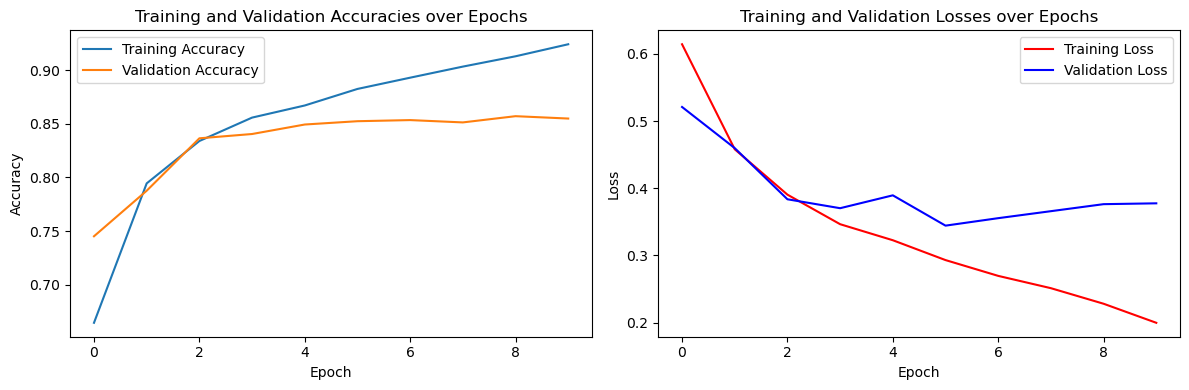

In [20]:
val_losses_cpu = [loss.cpu().item() for loss in val_losses]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies over Epochs')
plt.legend()

# Plot Training and Validation Losses
plt.subplot(1, 2, 2)
plt.plot(loss_list, label='Training Loss', color='r')
plt.plot(val_losses_cpu, label='Validation Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

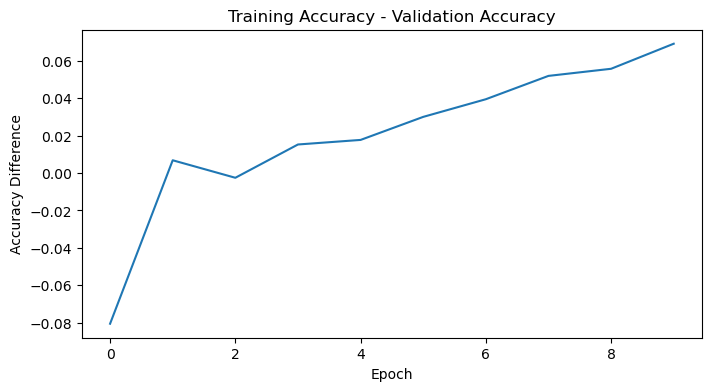

In [24]:
accuracy_diff = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]

plt.figure(figsize=(8, 4))
plt.plot(accuracy_diff)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Difference')
plt.title('Training Accuracy - Validation Accuracy')

plt.show()

Best validation accuracy is about 0.85

# Pre-trained BERT Model

First, loading BertForSequenceClassification and tokenizer for BERT

In [52]:
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
from transformers import InputExample, InputFeatures

model_BERT = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_BERT.to(device)
tokenizer_BERT = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using only first 10 thousand reviews

In [53]:
df_BERT = pd.read_csv('movie_data.csv', encoding = 'utf-8')[:10000]

Tokenizing

In [54]:
tokenized_texts = [tokenizer_BERT.encode(text, add_special_tokens=True) for text in df_BERT.iloc[:, 0].values]

Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors


Taking only 128 first words

In [55]:
max_length = 128

for i in range(len(tokenized_texts)):
    if len(tokenized_texts[i]) > max_length:
        tokenized_texts[i] = tokenized_texts[i][:max_length]

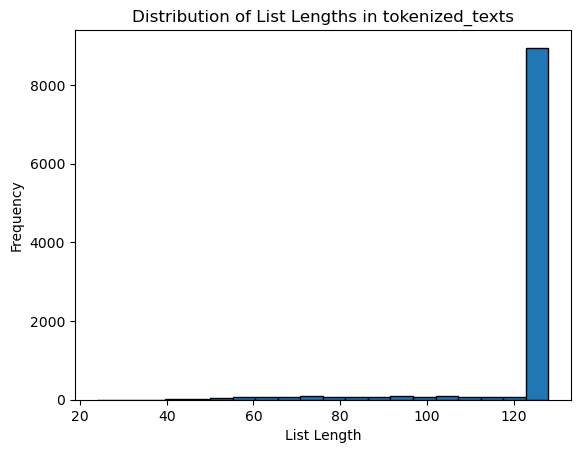

In [57]:
list_lengths = [len(lst) for lst in tokenized_texts]

plt.hist(list_lengths, bins=20, edgecolor='k')
plt.xlabel('List Length')
plt.ylabel('Frequency')
plt.title('Distribution of List Lengths in tokenized_texts')
plt.show()

Padding

In [65]:
padded_texts = padding(tokenized_texts, 128)

In [66]:
input_ids = torch.tensor(padded_texts)
labels = torch.tensor(df_BERT.iloc[:, 1].values)

Creating dataset and loaders

In [67]:
dataset = TensorDataset(input_ids, labels)

train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_dataloader = tqdm(train_dataloader, total=len(train_dataloader), desc="Training")

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_dataloader = tqdm(test_dataloader, total=len(test_dataloader), desc="Testing")

Testing:   0%|          | 0/250 [00:00<?, ?it/s]

Training

In [68]:
optimizer = torch.optim.AdamW(model_BERT.parameters(), lr=2e-5)

for epoch in range(3):
    model_BERT.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)
        outputs = model_BERT(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_dataloader.set_postfix({"loss": loss.item()})

Training: 100%|██████████| 63/63 [19:13<00:00, 18.31s/it, loss=0.593]


Evaluating results

In [69]:
model_BERT.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    input_ids, labels = batch
    input_ids, labels = input_ids.to(device), labels.to(device)  # Move input data to the GPU
    outputs = model_BERT(input_ids)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1))
    true_labels.extend(labels)


Testing: 100%|██████████| 250/250 [5:57:59<00:00, 85.92s/it]


BERT accuracy:

In [87]:
correct = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
accuracy = correct / len(true_labels)
print(accuracy)

0.847625


Let's see how the confusion matrix looks

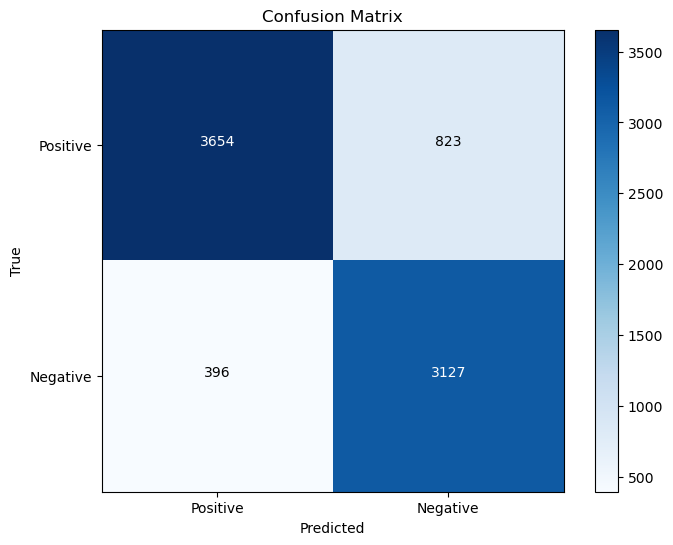

In [88]:
TP = 0
TN = 0
FP = 0
FN = 0

for true, pred in zip(true_labels, predictions):
    if true == 1 and pred == 1:
        TP += 1
    elif true == 0 and pred == 0:
        TN += 1
    elif true == 0 and pred == 1:
        FP += 1
    elif true == 1 and pred == 0:
        FN += 1
        
confusion_matrix = [[TP, FP], [FN, TN]]

class_labels = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = range(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(confusion_matrix[i][j]), horizontalalignment="center", color="white" if confusion_matrix[i][j] > confusion_matrix[0][1] else "black")

plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [83]:
torch.save(model_BERT.state_dict(), 'bert_imdb_sentiment_model.pth')

# Conclusion

Accuracies: LodisticRegression = 0.90, LSTM = 0.85, BERT = 0.85.

All models can be imroved, especialy BERT, where I used only a small portion of data due to hardware limitations.